In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, Model

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
 !unzip "/content/drive/MyDrive/Deep_Learning/Transfer_Learning/Intel_Image_MultiClass/test.zip" -d "/content/drive/MyDrive/Deep_Learning/Transfer_Learning/Intel_Image_MultiClass/test"

In [ ]:
 !unzip "/content/drive/MyDrive/Deep_Learning/Transfer_Learning/Intel_Image_MultiClass/train.zip" -d "/content/drive/MyDrive/Deep_Learning/Transfer_Learning/Intel_Image_MultiClass/train"

In [ ]:
 !unzip "/content/drive/MyDrive/Deep_Learning/Transfer_Learning/Intel_Image_MultiClass/validation.zip" -d "/content/drive/MyDrive/Deep_Learning/Transfer_Learning/Intel_Image_MultiClass/validation"

In [ ]:
!ls '/content/drive/MyDrive/Deep_Learning/Transfer_Learning/Intel_Image_MultiClass'

test  test.zip	train  train.zip  validation  validation.zip


In [3]:
path_train_dataset = '/content/drive/MyDrive/Deep_Learning/Transfer_Learning/Intel_Image_MultiClass/train/seg_train' 
path_validation_dataset = '/content/drive/MyDrive/Deep_Learning/Transfer_Learning/Intel_Image_MultiClass/validation/seg_test'

In [4]:

batch_size = 32
epochs = 30
IMG_HEIGHT = 150
IMG_WIDTH = 150

#Transfer Learning - InceptionResNetV2

In [5]:
train_datagen = ImageDataGenerator(rescale = 1.0/255,
                                   zoom_range = 0.2,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   rotation_range = 45,
                                   horizontal_flip = True)

validation_datagen = ImageDataGenerator(rescale = 1.0/255)

In [6]:
train_generator = train_datagen.flow_from_directory(directory = path_train_dataset,
                                                    target_size  =( IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size = batch_size,
                                                    shuffle = True,
                                                    class_mode = 'categorical')

validation_generator = validation_datagen.flow_from_directory(directory =path_validation_dataset,
                                  target_size=(IMG_WIDTH, IMG_HEIGHT),
                                  batch_size=batch_size,
                                  shuffle = True,
                                  class_mode='categorical')


Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [7]:
#Loading the InceptionResNetV2 arc with imagenet weights and bias

base_model = tf.keras.applications.InceptionResNetV2(include_top=False,
                                                     weights = 'imagenet',
                                                     input_shape = (150, 150, 3))

#Freezing the CNN layer

base_model.trainable = False

In [8]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.BatchNormalization( renorm = True),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

In [9]:
model.compile(optimizer='Adam', loss = 'categorical_crossentropy', metrics=['accuracy'])


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 3, 3, 1536)       54336736  
 onal)                                                           
                                                                 
 batch_normalization_203 (Ba  (None, 3, 3, 1536)       10752     
 tchNormalization)                                               
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 512)               786944    
                                                        

In [ ]:
model.fit(train_generator,
          steps_per_epoch = 14034//batch_size,
          epochs =5,
          validation_data= validation_generator,
          validation_steps=3000//batch_size)

Epoch 1/5
438/438 [==============================] - 3870s 9s/step - loss: 0.6461 - accuracy: 0.7680 - val_loss: 0.3528 - val_accuracy: 0.8881
Epoch 2/5
438/438 [==============================] - 115s 262ms/step - loss: 0.4861 - accuracy: 0.8262 - val_loss: 0.3052 - val_accuracy: 0.8921
Epoch 3/5
438/438 [==============================] - 115s 263ms/step - loss: 0.4478 - accuracy: 0.8395 - val_loss: 0.2879 - val_accuracy: 0.9009
Epoch 4/5
438/438 [==============================] - 115s 262ms/step - loss: 0.4267 - accuracy: 0.8495 - val_loss: 0.2861 - val_accuracy: 0.8955
Epoch 5/5
438/438 [==============================] - 115s 263ms/step - loss: 0.4071 - accuracy: 0.8577 - val_loss: 0.2687 - val_accuracy: 0.9059


In [ ]:
model.save('/content/drive/MyDrive/Deep_Learning/Transfer_Learning/intel.h5')

In [11]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/Deep_Learning/Transfer_Learning/intel.h5')


In [12]:
path_test_dataset = '/content/drive/MyDrive/Deep_Learning/Transfer_Learning/Intel_Image_MultiClass/validation/seg_test'

In [13]:
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(directory =path_test_dataset,
                                  target_size=(IMG_WIDTH,IMG_HEIGHT),
                                  batch_size=batch_size,
                                  shuffle = False,
                                  class_mode='categorical')


Found 3000 images belonging to 6 classes.


In [14]:
# !pip install tensorflow==2.8
# !apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2


In [15]:
prediction = model.predict(test_generator)

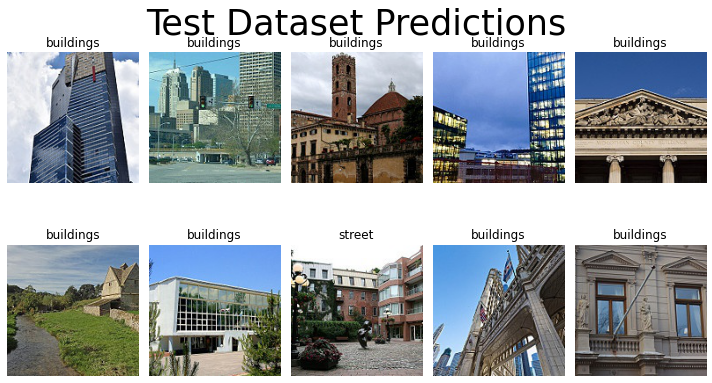

In [17]:
labels = {value: key for key, value in train_generator.class_indices.items()}

fig, ax = plt.subplots(nrows=2,ncols=5,figsize=(10,6))
ind = 0
for i in range(2):
  for j in range(5):
    predicted_label = labels[np.argmax(prediction[ind])]
    ax[i, j].set_title(f'{predicted_label}')
    ax[i, j].imshow(test_generator[0][0][ind])
    ax[i, j].axis('off')
    ind += 1
plt.tight_layout()
plt.suptitle('Test Dataset Predictions', fontsize=35)
plt.show()

In [18]:
  val_loss, val_accuracy =model.evaluate(test_generator,batch_size=batch_size)
print(f"The loss of validation dataset is {val_loss}")
print(f"The Accuracy of validation dataset is {val_accuracy}")


94/94 [==============================] - 12s 93ms/step - loss: 0.2681 - accuracy: 0.9060
The loss of validation dataset is 0.268125981092453
The Accuracy of validation dataset is 0.906000018119812


In [16]:
prediction

array([[9.9800092e-01, 5.3168083e-08, 1.3006742e-06, 1.3958817e-06,
        2.4274709e-06, 1.9939214e-03],
       [5.4345363e-01, 1.3107734e-04, 2.4292477e-04, 3.8934817e-05,
        1.0436194e-03, 4.5508978e-01],
       [9.9471480e-01, 1.9182779e-07, 8.1645776e-06, 2.6745931e-06,
        3.2649968e-05, 5.2415533e-03],
       ...,
       [7.3519577e-03, 1.9683957e-02, 8.8682391e-02, 6.1613131e-01,
        2.5915807e-01, 8.9922966e-03],
       [3.3373523e-01, 1.9301842e-03, 5.0985976e-03, 1.4950333e-03,
        2.2042958e-02, 6.3569796e-01],
       [4.6311587e-02, 5.9163940e-06, 2.1791355e-07, 1.9806052e-09,
        1.2913114e-06, 9.5368105e-01]], dtype=float32)

In [20]:
np.argmax(prediction, axis=1)

array([0, 0, 0, ..., 3, 5, 5])

In [21]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


In [22]:
y_pred= np.argmax(prediction,axis=1)
y_true = test_generator.classes


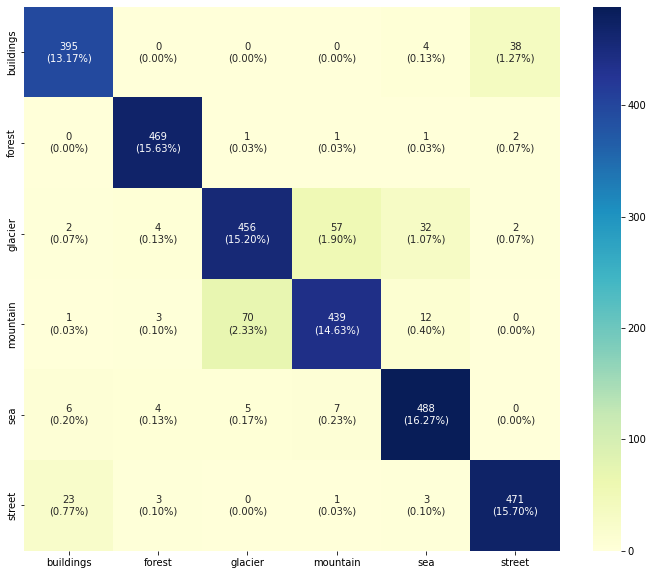

In [23]:
cf_mtx = confusion_matrix(y_true,y_pred)
group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(6, 6)

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)

In [ ]:
print(classification_report(y_true, y_pred, ))